In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
from setup_mnist import MNIST
from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if not os.path.isdir('models'):
    os.makedirs('models')

# train(CIFAR(), "models/cifar", [64, 64, 128, 128, 256, 256], num_epochs=50)
train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs=50)

train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200],
                   num_epochs=50, train_temp=100)
# train_distillation(CIFAR(), "models/cifar-distilled-100", [64, 64, 128, 128, 256, 256],
#                    num_epochs=50, train_temp=100)

(55000, 28, 28, 1)


/home/tianwei/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.6842 - acc: 0.7719 - val_loss: 0.0860 - val_acc: 0.9740
Epoch 2/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.1227 - acc: 0.9626 - val_loss: 0.0608 - val_acc: 0.9824
Epoch 3/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0869 - acc: 0.9734 - val_loss: 0.0484 - val_acc: 0.9870
Epoch 4/50
55000/55000 [==============================] - 4s 72us/step - loss: 0.0719 - acc: 0.9784 - val_loss: 0.0487 - val_acc: 0.9860
Epoch 5/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0614 - acc: 0.9825 - val_loss: 0.0426 - val_acc: 0.9884
Epoch 6/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0530 - acc: 0.9842 - val_loss: 0.0370 - val_acc: 0.9904
Epoch 7/50
55000/55000 [==============================] - 4s 71us/step - loss: 0.0464 - acc: 0.9851 - val_loss: 0.0379 - val_acc:

55000/55000 [==============================] - 4s 70us/step - loss: 0.0450 - acc: 0.9859 - val_loss: 0.0414 - val_acc: 0.9892
Epoch 13/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0405 - acc: 0.9875 - val_loss: 0.0420 - val_acc: 0.9896
Epoch 14/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0391 - acc: 0.9881 - val_loss: 0.0416 - val_acc: 0.9906
Epoch 15/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.0375 - acc: 0.9883 - val_loss: 0.0417 - val_acc: 0.9892
Epoch 16/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.0357 - acc: 0.9887 - val_loss: 0.0389 - val_acc: 0.9894
Epoch 17/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.0344 - acc: 0.9893 - val_loss: 0.0425 - val_acc: 0.9892
Epoch 18/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0323 - acc: 0.9899 - val_loss: 0.0393 - val_acc: 0.9894
Epoch 19/50
55000/55000 [=====================

In [2]:
import tensorflow as tf
import numpy as np
import time

from setup_cifar import CIFAR, CIFARModel
from setup_mnist import MNIST, MNISTModel
from setup_inception import ImageNet, InceptionModel

from l2_attack import CarliniL2
from l0_attack import CarliniL0
from li_attack import CarliniLi


# def show(img):
#     """
#     Show MNSIT digits in the console.
#     """
#     remap = "  .*#"+"#"*100
#     img = (img.flatten()+.5)*3
#     if len(img) != 784: return
#     print("START")
#     for i in range(28):
#         print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(data.test_labels.shape[1])

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [8]:
# sess = tf.Session()
# tf.global_variables_initializer().run()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

data, model =  MNIST(), MNISTModel("models/mnist", sess)
attack = CarliniL0(sess, model,  max_iterations=100)
# attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)

inputs, targets = generate_data(data, samples=1, targeted=True,
                                start=0, inception=False)

In [9]:
print(inputs.shape )
print(targets )

(9, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [10]:
timestart = time.time()
adv = attack.attack(inputs, targets)
timeend = time.time()

print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")

Attack iteration 0
try const 0.001
0 [38.41788] 0.0
10 [38.305077] 0.00026566358
20 [38.329338] 0.000121203506
30 [38.351707] 5.031513e-05
40 [38.36245] 3.3544606e-05
50 [38.365833] 2.8538709e-05
60 [38.36689] 2.6693737e-05
70 [38.368786] 2.4587778e-05
80 [38.36867] 2.464797e-05
90 [38.368446] 2.4798075e-05
try const 0.002
0 [38.368687] 2.4531406e-05
10 [38.30008] 0.00014239915
20 [38.319847] 9.944214e-05
30 [38.321674] 9.486305e-05
40 [38.319027] 9.9700745e-05
50 [38.320377] 9.686811e-05
60 [38.32011] 9.73234e-05
70 [38.319622] 9.830156e-05
80 [38.320057] 9.742084e-05
90 [38.319942] 9.7661636e-05
try const 0.004
0 [38.319897] 9.773808e-05
10 [38.18799] 0.0005480881
20 [38.235977] 0.00034211364
30 [38.219444] 0.00040482706
40 [38.223915] 0.0003853979
50 [38.22311] 0.00038831405
60 [38.22291] 0.000389005
70 [38.2238] 0.00038546298
80 [38.22268] 0.000389902
90 [38.22333] 0.0003873043
try const 0.008
0 [38.22339] 0.0003870714
10 [37.997635] 0.0018788977
20 [38.046616] 0.0014320959
30 [38.

Forced equal: 360.0 Equal count: 344
Now forced equal: 366.0
try const 1.024
0 [0.] 8.493156
Forced equal: 366.0 Equal count: 344
Now forced equal: 372.0
try const 1.024
0 [0.] 8.493163
Forced equal: 372.0 Equal count: 344
Now forced equal: 378.0
try const 1.024
0 [0.] 8.493169
Forced equal: 378.0 Equal count: 344
Now forced equal: 384.0
try const 1.024
0 [0.] 8.493176
Forced equal: 384.0 Equal count: 344
Now forced equal: 390.0
try const 1.024
0 [0.] 8.493183
Forced equal: 390.0 Equal count: 344
Now forced equal: 396.0
try const 1.024
0 [0.] 8.49319
Forced equal: 396.0 Equal count: 344
Now forced equal: 402.0
try const 1.024
0 [0.] 8.4931965
Forced equal: 402.0 Equal count: 344
Now forced equal: 408.0
try const 1.024
0 [0.] 8.493203
Forced equal: 408.0 Equal count: 344
Now forced equal: 414.0
try const 1.024
0 [0.] 8.493209
Forced equal: 414.0 Equal count: 344
Now forced equal: 420.0
try const 1.024
0 [0.] 8.4932165
Forced equal: 420.0 Equal count: 344
Now forced equal: 426.0
try cons

try const 1.024
0 [0.04038335] 9.678333
Forced equal: 690.0 Equal count: 94
Now forced equal: 691.0
try const 1.024
0 [0.02451182] 9.668974
Forced equal: 691.0 Equal count: 93
Now forced equal: 692.0
try const 1.024
0 [0.04295755] 9.665081
Forced equal: 692.0 Equal count: 92
Now forced equal: 693.0
try const 1.024
0 [0.07277466] 9.643877
Forced equal: 693.0 Equal count: 91
Now forced equal: 694.0
try const 1.024
0 [0.11829305] 9.586656
Forced equal: 694.0 Equal count: 90
Now forced equal: 695.0
try const 1.024
0 [0.07774068] 9.625426
Forced equal: 695.0 Equal count: 89
Now forced equal: 696.0
try const 1.024
0 [0.02993799] 9.614252
Forced equal: 696.0 Equal count: 88
Now forced equal: 697.0
try const 1.024
0 [0.08440257] 9.652288
Forced equal: 697.0 Equal count: 87
Now forced equal: 698.0
try const 1.024
0 [0.03906561] 9.659174
Forced equal: 698.0 Equal count: 86
Now forced equal: 699.0
try const 1.024
0 [0.] 9.730877
Forced equal: 699.0 Equal count: 85
Now forced equal: 700.0
try cons

70 [1.5219824] 17.51464
80 [1.4930027] 17.614834
90 [1.4694777] 17.711798
try const 32.768
0 [1.4534361] 17.766937
10 [1.4366047] 17.862215
20 [1.4173744] 17.94664
30 [1.4093428] 18.067549
40 [1.3832605] 18.113544
50 [1.3544819] 18.206661
60 [1.3403211] 18.271414
70 [1.3230441] 18.340782
80 [1.3149087] 18.388391
90 [1.3105564] 18.426384
try const 65.536
0 [1.3017201] 18.493917
10 [1.2908304] 18.541056
20 [1.3048592] 18.555944
30 [1.2847748] 18.657894
40 [1.2662921] 18.672071
50 [1.2524123] 18.718834
60 [1.257966] 18.741304
70 [1.2412326] 18.794052
80 [1.2315109] 18.817984
90 [1.2304521] 18.849674
try const 131.072
0 [1.2295904] 18.87941
10 [1.2412925] 18.938345
20 [1.2187233] 18.935438
30 [1.2132182] 18.972977
40 [1.2300577] 18.97936
50 [1.2314248] 19.004202
60 [1.1987982] 19.07915
70 [1.1966784] 19.105774
80 [1.1966145] 19.130045
90 [1.2018504] 19.168064
try const 262.144
0 [1.1895077] 19.169306
10 [1.1839361] 19.20615
20 [1.1891668] 19.220276
30 [1.1789796] 19.247799
40 [1.176965] 19

try const 1.024
0 [0.] 6.645275
Forced equal: 108.0 Equal count: 289
Now forced equal: 114.0
try const 1.024
0 [0.] 6.6452804
Forced equal: 114.0 Equal count: 289
Now forced equal: 120.0
try const 1.024
0 [0.] 6.6452837
Forced equal: 120.0 Equal count: 289
Now forced equal: 126.0
try const 1.024
0 [0.] 6.645288
Forced equal: 126.0 Equal count: 289
Now forced equal: 132.0
try const 1.024
0 [0.] 6.645292
Forced equal: 132.0 Equal count: 289
Now forced equal: 138.0
try const 1.024
0 [0.] 6.6452956
Forced equal: 138.0 Equal count: 289
Now forced equal: 144.0
try const 1.024
0 [0.] 6.6453
Forced equal: 144.0 Equal count: 289
Now forced equal: 150.0
try const 1.024
0 [0.] 6.6453047
Forced equal: 150.0 Equal count: 289
Now forced equal: 156.0
try const 1.024
0 [0.] 6.6453085
Forced equal: 156.0 Equal count: 289
Now forced equal: 162.0
try const 1.024
0 [0.] 6.645312
Forced equal: 162.0 Equal count: 289
Now forced equal: 168.0
try const 1.024
0 [0.] 6.6453166
Forced equal: 168.0 Equal count: 2

0 [0.] 6.5998535
Forced equal: 614.0 Equal count: 170
Now forced equal: 618.0
try const 1.024
0 [0.] 6.5953126
Forced equal: 618.0 Equal count: 166
Now forced equal: 622.0
try const 1.024
0 [0.] 6.589665
Forced equal: 622.0 Equal count: 162
Now forced equal: 626.0
try const 1.024
0 [0.] 6.582026
Forced equal: 626.0 Equal count: 158
Now forced equal: 630.0
try const 1.024
0 [0.] 6.5715094
Forced equal: 630.0 Equal count: 154
Now forced equal: 634.0
try const 1.024
0 [0.] 6.5630507
Forced equal: 634.0 Equal count: 150
Now forced equal: 638.0
try const 1.024
0 [0.] 6.5459385
Forced equal: 638.0 Equal count: 146
Now forced equal: 642.0
try const 1.024
0 [0.] 6.525096
Forced equal: 642.0 Equal count: 142
Now forced equal: 646.0
try const 1.024
0 [0.14404704] 6.4927926
Forced equal: 646.0 Equal count: 138
Now forced equal: 650.0
try const 1.024
0 [0.06323887] 6.4536033
Forced equal: 650.0 Equal count: 134
Now forced equal: 654.0
try const 1.024
0 [0.] 6.4924107
Forced equal: 654.0 Equal coun

try const 2.048
0 [0.02765823] 9.472629
Forced equal: 756.0 Equal count: 28
Now forced equal: 757.0
try const 2.048
0 [0.22233035] 9.430509
Forced equal: 757.0 Equal count: 27
Now forced equal: 758.0
try const 2.048
0 [1.7783902] 9.174948
10 [0.7154248] 10.189676
Forced equal: 758.0 Equal count: 26
Now forced equal: 759.0
try const 2.048
0 [0.58498263] 10.834144
10 [0.0256889] 11.486825
Forced equal: 759.0 Equal count: 25
Now forced equal: 760.0
try const 2.048
0 [0.27291512] 11.294891
10 [0.04108263] 11.538515
Forced equal: 760.0 Equal count: 24
Now forced equal: 761.0
try const 2.048
0 [0.50871444] 11.273113
Forced equal: 761.0 Equal count: 23
Now forced equal: 762.0
try const 2.048
0 [0.20275618] 11.887626
Forced equal: 762.0 Equal count: 22
Now forced equal: 763.0
try const 2.048
0 [1.5088389] 11.388172
10 [0.98680806] 12.001788
20 [0.6783078] 12.460172
30 [0.53203607] 12.64158
40 [0.4878404] 12.642458
50 [0.4183705] 12.702246
60 [0.3682344] 12.74888
70 [0.28443933] 12.892093
80 [0

10 [29.80574] 0.023534896
20 [29.550413] 0.030403666
30 [29.592865] 0.02783659
40 [29.517809] 0.028828667
50 [29.39755] 0.0312517
60 [29.33228] 0.032721814
70 [29.317806] 0.032319456
80 [29.246105] 0.034051787
90 [29.222383] 0.03436497
try const 0.064
0 [29.206411] 0.034371316
10 [27.283978] 0.12463902
20 [26.843601] 0.15092057
30 [27.23597] 0.12343921
40 [27.076553] 0.13174048
50 [27.027983] 0.13409956
60 [27.033163] 0.13323702
70 [26.940535] 0.13828823
80 [26.93453] 0.13791943
90 [26.916245] 0.13840495
try const 0.128
0 [26.908228] 0.13827318
10 [23.267832] 0.49046487
20 [21.187452] 0.6669091
30 [15.181942] 1.0939766
40 [12.947969] 1.2037834
50 [11.904719] 1.2909731
60 [11.784868] 1.2699894
70 [11.894438] 1.2414377
80 [11.910488] 1.227109
90 [11.644784] 1.2487386
try const 0.256
0 [11.606153] 1.2505184
10 [5.7752485] 2.4053824
20 [2.4816864] 3.0205345
30 [2.3287752] 2.9386759
40 [1.5175455] 3.035047
50 [1.0712211] 3.0545578
60 [0.85632014] 3.0415902
70 [0.87586665] 2.984134
80 [0.583

Forced equal: 465.0 Equal count: 275
Now forced equal: 470.0
try const 0.512
0 [0.] 3.261404
Forced equal: 470.0 Equal count: 275
Now forced equal: 475.0
try const 0.512
0 [0.] 3.2614076
Forced equal: 475.0 Equal count: 275
Now forced equal: 480.0
try const 0.512
0 [0.] 3.2614107
Forced equal: 480.0 Equal count: 275
Now forced equal: 485.0
try const 0.512
0 [0.] 3.261414
Forced equal: 485.0 Equal count: 275
Now forced equal: 490.0
try const 0.512
0 [0.] 3.2614174
Forced equal: 490.0 Equal count: 275
Now forced equal: 495.0
try const 0.512
0 [0.] 3.2614207
Forced equal: 495.0 Equal count: 275
Now forced equal: 500.0
try const 0.512
0 [0.] 3.261424
Forced equal: 500.0 Equal count: 275
Now forced equal: 505.0
try const 0.512
0 [0.] 3.2614274
Forced equal: 505.0 Equal count: 275
Now forced equal: 510.0
try const 0.512
0 [0.] 3.2614303
Forced equal: 510.0 Equal count: 273
Now forced equal: 515.0
try const 0.512
0 [0.] 3.2614336
Forced equal: 515.0 Equal count: 268
Now forced equal: 520.0
tr

0 [0.16340424] 4.660413
Forced equal: 747.0 Equal count: 37
Now forced equal: 748.0
try const 0.512
0 [0.13627793] 4.705653
Forced equal: 748.0 Equal count: 36
Now forced equal: 749.0
try const 0.512
0 [0.29518867] 4.686643
Forced equal: 749.0 Equal count: 35
Now forced equal: 750.0
try const 0.512
0 [0.20383717] 4.795306
Forced equal: 750.0 Equal count: 34
Now forced equal: 751.0
try const 0.512
0 [0.17569901] 4.834945
10 [0.07811237] 4.859208
20 [0.08220554] 4.8406396
30 [0.02255989] 4.8593125
40 [0.01599289] 4.8552837
50 [0.00894428] 4.85781
Forced equal: 751.0 Equal count: 33
Now forced equal: 752.0
try const 0.512
0 [0.27567935] 4.8215027
10 [0.09378124] 4.9063535
20 [0.14513089] 4.8791
30 [0.15630318] 4.8722186
40 [0.11857105] 4.8912106
50 [0.12115265] 4.890132
60 [0.1111343] 4.895101
70 [0.09234882] 4.9036574
80 [0.13830926] 4.8802
90 [0.12604024] 4.8868217
try const 1.024
0 [0.1231382] 4.8887057
Forced equal: 752.0 Equal count: 32
Now forced equal: 753.0
try const 1.024
0 [0.27

80 [3.1995513] 12.48664
90 [3.1993663] 12.487989
try const 1073741.824
0 [3.1993873] 12.494471
10 [3.1993873] 12.494365
20 [3.1995132] 12.486886
30 [3.1993434] 12.492855
40 [3.1995523] 12.503354
50 [3.1994798] 12.497761
60 [3.1994483] 12.496509
70 [3.1992815] 12.490576
80 [3.1994054] 12.495043
90 [3.1994884] 12.498076
Final answer 14
Attack iteration 3
try const 0.001
0 [30.078156] 0.0
10 [29.975704] 0.0002635264
20 [30.001095] 0.00011799902
30 [30.023554] 4.5198525e-05
40 [30.033676] 2.823823e-05
50 [30.037207] 2.3142362e-05
60 [30.03915] 2.053744e-05
70 [30.040218] 1.929222e-05
80 [30.040272] 1.9136105e-05
90 [30.040354] 1.8986335e-05
try const 0.002
0 [30.040693] 1.8622806e-05
10 [29.987986] 0.00010944655
20 [30.003767] 7.4656455e-05
30 [30.006168] 6.928147e-05
40 [30.001286] 7.878654e-05
50 [30.00413] 7.2955525e-05
60 [30.002974] 7.5279015e-05
70 [30.003376] 7.4452546e-05
80 [30.003288] 7.462838e-05
90 [30.00334] 7.4523945e-05
try const 0.004
0 [30.003325] 7.453716e-05
10 [29.89508

Forced equal: 350.0 Equal count: 238
Now forced equal: 355.0
try const 0.256
0 [0.] 3.2931802
Forced equal: 355.0 Equal count: 238
Now forced equal: 360.0
try const 0.256
0 [0.] 3.2931836
Forced equal: 360.0 Equal count: 238
Now forced equal: 365.0
try const 0.256
0 [0.] 3.2931867
Forced equal: 365.0 Equal count: 238
Now forced equal: 370.0
try const 0.256
0 [0.] 3.2931893
Forced equal: 370.0 Equal count: 238
Now forced equal: 375.0
try const 0.256
0 [0.] 3.2931921
Forced equal: 375.0 Equal count: 238
Now forced equal: 380.0
try const 0.256
0 [0.] 3.2931948
Forced equal: 380.0 Equal count: 238
Now forced equal: 385.0
try const 0.256
0 [0.] 3.2931979
Forced equal: 385.0 Equal count: 238
Now forced equal: 390.0
try const 0.256
0 [0.] 3.293201
Forced equal: 390.0 Equal count: 238
Now forced equal: 395.0
try const 0.256
0 [0.] 3.2932038
Forced equal: 395.0 Equal count: 238
Now forced equal: 400.0
try const 0.256
0 [0.] 3.2932067
Forced equal: 400.0 Equal count: 238
Now forced equal: 405.0


Forced equal: 745.0 Equal count: 39
Now forced equal: 746.0
try const 0.256
0 [0.14322259] 3.3288546
Forced equal: 746.0 Equal count: 38
Now forced equal: 747.0
try const 0.256
0 [0.04902626] 3.3367674
Forced equal: 747.0 Equal count: 37
Now forced equal: 748.0
try const 0.256
0 [0.] 3.3846474
Forced equal: 748.0 Equal count: 36
Now forced equal: 749.0
try const 0.256
0 [0.11964203] 3.3487647
Forced equal: 749.0 Equal count: 35
Now forced equal: 750.0
try const 0.256
0 [0.] 3.4038672
Forced equal: 750.0 Equal count: 34
Now forced equal: 751.0
try const 0.256
0 [0.20137574] 3.372144
Forced equal: 751.0 Equal count: 33
Now forced equal: 752.0
try const 0.256
0 [0.04988647] 3.4164686
Forced equal: 752.0 Equal count: 32
Now forced equal: 753.0
try const 0.256
0 [0.] 3.458675
Forced equal: 753.0 Equal count: 31
Now forced equal: 754.0
try const 0.256
0 [0.12432266] 3.4238982
Forced equal: 754.0 Equal count: 30
Now forced equal: 755.0
try const 0.256
0 [0.2663839] 3.452138
Forced equal: 755.

50 [3.8458793] 6.52275
60 [3.8458793] 6.52275
70 [3.8458793] 6.52275
80 [3.8458793] 6.52275
90 [3.8458793] 6.52275
try const 268435.456
0 [3.8458793] 6.52275
10 [3.8458793] 6.52275
20 [3.8458793] 6.52275
30 [3.8458793] 6.52275
40 [3.8458793] 6.52275
50 [3.8458793] 6.52275
60 [3.8458793] 6.52275
70 [3.8458793] 6.52275
80 [3.8458793] 6.5227494
90 [3.8458793] 6.5227494
try const 536870.912
0 [3.8458793] 6.52275
10 [3.8458793] 6.52275
20 [3.8458793] 6.52275
30 [3.8458793] 6.52275
40 [3.8458793] 6.52275
50 [3.8458793] 6.52275
60 [3.8458793] 6.52275
70 [3.8458793] 6.52275
80 [3.8458793] 6.52275
90 [3.8458793] 6.52275
try const 1073741.824
0 [3.8458793] 6.52275
10 [3.8458793] 6.52275
20 [3.8458793] 6.52275
30 [3.8458793] 6.52275
40 [3.8458793] 6.52275
50 [3.8458793] 6.52275
60 [3.8458793] 6.52275
70 [3.8458793] 6.52275
80 [3.8458793] 6.52275
90 [3.8458793] 6.52275
Final answer 8
Attack iteration 4
try const 0.001
0 [32.756897] 0.0
10 [32.657574] 0.00026486922
20 [32.68179] 0.00011453141
30 [3

Forced equal: 390.0 Equal count: 335
Now forced equal: 396.0
try const 2.048
0 [0.] 7.4135103
Forced equal: 396.0 Equal count: 335
Now forced equal: 402.0
try const 2.048
0 [0.] 7.413515
Forced equal: 402.0 Equal count: 335
Now forced equal: 408.0
try const 2.048
0 [0.] 7.413521
Forced equal: 408.0 Equal count: 335
Now forced equal: 414.0
try const 2.048
0 [0.] 7.413526
Forced equal: 414.0 Equal count: 335
Now forced equal: 420.0
try const 2.048
0 [0.] 7.413532
Forced equal: 420.0 Equal count: 335
Now forced equal: 426.0
try const 2.048
0 [0.] 7.4135365
Forced equal: 426.0 Equal count: 335
Now forced equal: 432.0
try const 2.048
0 [0.] 7.4135423
Forced equal: 432.0 Equal count: 335
Now forced equal: 438.0
try const 2.048
0 [0.] 7.4135475
Forced equal: 438.0 Equal count: 335
Now forced equal: 444.0
try const 2.048
0 [0.] 7.4135523
Forced equal: 444.0 Equal count: 335
Now forced equal: 450.0
try const 2.048
0 [0.] 7.4135585
Forced equal: 450.0 Equal count: 334
Now forced equal: 456.0
try

Forced equal: 711.0 Equal count: 73
Now forced equal: 712.0
try const 2.048
0 [0.07397009] 9.253062
Forced equal: 712.0 Equal count: 72
Now forced equal: 713.0
try const 2.048
0 [0.02451445] 9.406715
Forced equal: 713.0 Equal count: 71
Now forced equal: 714.0
try const 2.048
0 [0.00616003] 9.4426155
Forced equal: 714.0 Equal count: 70
Now forced equal: 715.0
try const 2.048
0 [0.] 9.5097885
Forced equal: 715.0 Equal count: 69
Now forced equal: 716.0
try const 2.048
0 [0.08651877] 9.4571705
Forced equal: 716.0 Equal count: 68
Now forced equal: 717.0
try const 2.048
0 [0.] 9.5930605
Forced equal: 717.0 Equal count: 67
Now forced equal: 718.0
try const 2.048
0 [0.13138773] 9.518082
Forced equal: 718.0 Equal count: 66
Now forced equal: 719.0
try const 2.048
0 [0.02980591] 9.662204
Forced equal: 719.0 Equal count: 65
Now forced equal: 720.0
try const 2.048
0 [0.15821816] 9.665659
Forced equal: 720.0 Equal count: 64
Now forced equal: 721.0
try const 2.048
0 [0.02631045] 9.851172
Forced equal

40 [0.4628458] 21.306297
50 [0.45784748] 21.26939
60 [0.4600854] 21.272978
70 [0.45809543] 21.292233
80 [0.45898104] 21.30985
90 [0.45987272] 21.322918
try const 67108.864
0 [0.45806372] 21.312489
10 [0.45853686] 21.327442
20 [0.46271896] 21.29167
30 [0.45785487] 21.326515
40 [0.46143305] 21.340479
50 [0.4583708] 21.330124
60 [0.456787] 21.354046
70 [0.4564761] 21.3364
80 [0.4564973] 21.360113
90 [0.45705473] 21.343239
try const 134217.728
0 [0.45766664] 21.373596
10 [0.45753503] 21.35918
20 [0.45788836] 21.340363
30 [0.45701873] 21.3561
40 [0.45723927] 21.336185
50 [0.4587419] 21.358246
60 [0.4562776] 21.38352
70 [0.45684993] 21.37051
80 [0.45576918] 21.377419
90 [0.4549644] 21.390018
try const 268435.456
0 [0.4558276] 21.378016
10 [0.4585166] 21.394575
20 [0.45487213] 21.38721
30 [0.4562986] 21.394543
40 [0.45824575] 21.358622
50 [0.4549719] 21.390352
60 [0.45494843] 21.399075
70 [0.4539119] 21.393606
80 [0.45374012] 21.393993
90 [0.45292497] 21.389454
try const 536870.912
0 [0.45563

Forced equal: 230.0 Equal count: 264
Now forced equal: 235.0
try const 0.256
0 [0.] 4.615282
Forced equal: 235.0 Equal count: 264
Now forced equal: 240.0
try const 0.256
0 [0.] 4.615285
Forced equal: 240.0 Equal count: 264
Now forced equal: 245.0
try const 0.256
0 [0.] 4.6152883
Forced equal: 245.0 Equal count: 264
Now forced equal: 250.0
try const 0.256
0 [0.] 4.6152906
Forced equal: 250.0 Equal count: 264
Now forced equal: 255.0
try const 0.256
0 [0.] 4.6152945
Forced equal: 255.0 Equal count: 264
Now forced equal: 260.0
try const 0.256
0 [0.] 4.615297
Forced equal: 260.0 Equal count: 264
Now forced equal: 265.0
try const 0.256
0 [0.] 4.6153
Forced equal: 265.0 Equal count: 264
Now forced equal: 270.0
try const 0.256
0 [0.] 4.6153026
Forced equal: 270.0 Equal count: 264
Now forced equal: 275.0
try const 0.256
0 [0.] 4.6153054
Forced equal: 275.0 Equal count: 264
Now forced equal: 280.0
try const 0.256
0 [0.] 4.615309
Forced equal: 280.0 Equal count: 264
Now forced equal: 285.0
try co

Forced equal: 704.0 Equal count: 80
Now forced equal: 707.0
try const 0.256
0 [0.] 4.8574243
Forced equal: 707.0 Equal count: 77
Now forced equal: 710.0
try const 0.256
0 [0.11269737] 4.8292346
Forced equal: 710.0 Equal count: 74
Now forced equal: 713.0
try const 0.256
0 [0.0452478] 4.863889
Forced equal: 713.0 Equal count: 71
Now forced equal: 716.0
try const 0.256
0 [0.3523662] 4.8839674
Forced equal: 716.0 Equal count: 68
Now forced equal: 719.0
try const 0.256
0 [0.45376277] 4.9248943
10 [0.30748916] 4.915107
Forced equal: 719.0 Equal count: 65
Now forced equal: 722.0
try const 0.256
0 [0.27200103] 4.950205
Forced equal: 722.0 Equal count: 62
Now forced equal: 725.0
try const 0.256
0 [1.2850311] 4.927341
10 [0.35313964] 5.089192
Forced equal: 725.0 Equal count: 59
Now forced equal: 728.0
try const 0.256
0 [0.28470016] 5.127666
Forced equal: 728.0 Equal count: 56
Now forced equal: 729.0
try const 0.256
0 [0.] 5.216098
Forced equal: 729.0 Equal count: 55
Now forced equal: 730.0
try c

90 [0.33481097] 13.329716
try const 2097.152
0 [0.3261478] 13.328493
10 [0.37356257] 13.326418
20 [0.32421947] 13.33681
30 [0.33630538] 13.347027
40 [0.3286655] 13.344404
50 [0.32878566] 13.351854
60 [0.3312919] 13.355922
70 [0.33201194] 13.358771
80 [0.3248384] 13.355669
90 [0.3303554] 13.362306
try const 4194.304
0 [0.35306048] 13.3562155
10 [0.3342197] 13.368369
20 [0.328923] 13.368634
30 [0.3243425] 13.368807
40 [0.32861876] 13.372448
50 [0.32894492] 13.373361
60 [0.33152843] 13.375275
70 [0.33018088] 13.374766
80 [0.32102084] 13.370261
90 [0.3220098] 13.371829
try const 8388.608
0 [0.32419944] 13.373416
10 [0.34015536] 13.381586
20 [0.35158706] 13.368193
30 [0.33581233] 13.37932
40 [0.37832808] 13.365515
50 [0.36301208] 13.390816
60 [0.325238] 13.374114
70 [0.32488418] 13.374132
80 [0.32299113] 13.373575
90 [0.34248424] 13.38299
try const 16777.216
0 [0.32907176] 13.377565
10 [0.35053325] 13.37049
20 [0.32744002] 13.377512
30 [0.34772182] 13.370388
40 [0.32112765] 13.373863
50 [0.

Now forced equal: 96.0
try const 32.768
0 [0.] 11.712398
Forced equal: 96.0 Equal count: 373
Now forced equal: 102.0
try const 32.768
0 [0.] 11.712404
Forced equal: 102.0 Equal count: 373
Now forced equal: 108.0
try const 32.768
0 [0.] 11.71241
Forced equal: 108.0 Equal count: 373
Now forced equal: 114.0
try const 32.768
0 [0.] 11.712416
Forced equal: 114.0 Equal count: 373
Now forced equal: 120.0
try const 32.768
0 [0.] 11.71242
Forced equal: 120.0 Equal count: 373
Now forced equal: 126.0
try const 32.768
0 [0.] 11.712426
Forced equal: 126.0 Equal count: 373
Now forced equal: 132.0
try const 32.768
0 [0.] 11.712432
Forced equal: 132.0 Equal count: 373
Now forced equal: 138.0
try const 32.768
0 [0.] 11.712439
Forced equal: 138.0 Equal count: 373
Now forced equal: 144.0
try const 32.768
0 [0.] 11.712443
Forced equal: 144.0 Equal count: 373
Now forced equal: 150.0
try const 32.768
0 [0.] 11.712449
Forced equal: 150.0 Equal count: 373
Now forced equal: 156.0
try const 32.768
0 [0.] 11.712

Forced equal: 622.0 Equal count: 162
Now forced equal: 626.0
try const 32.768
0 [0.14725061] 12.347279
Forced equal: 626.0 Equal count: 158
Now forced equal: 630.0
try const 32.768
0 [0.05265094] 12.221252
Forced equal: 630.0 Equal count: 154
Now forced equal: 634.0
try const 32.768
0 [0.00094629] 12.285108
Forced equal: 634.0 Equal count: 150
Now forced equal: 638.0
try const 32.768
0 [0.09298111] 12.536507
Forced equal: 638.0 Equal count: 146
Now forced equal: 642.0
try const 32.768
0 [0.17956908] 12.54567
Forced equal: 642.0 Equal count: 142
Now forced equal: 646.0
try const 32.768
0 [0.32194936] 12.440503
Forced equal: 646.0 Equal count: 138
Now forced equal: 648.0
try const 32.768
0 [0.04134089] 13.058964
Forced equal: 648.0 Equal count: 136
Now forced equal: 649.0
try const 32.768
0 [0.02589656] 12.870991
Forced equal: 649.0 Equal count: 135
Now forced equal: 650.0
try const 32.768
0 [0.] 12.960856
Forced equal: 650.0 Equal count: 134
Now forced equal: 651.0
try const 32.768
0 [0

20 [0.29411876] 20.441341
30 [0.18909402] 20.628675
40 [0.10344893] 20.934528
50 [0.08047903] 20.896603
60 [0.06254802] 20.989336
70 [0.05127323] 20.95299
80 [0.03762079] 20.942486
90 [0.02674443] 21.07423
try const 65.536
0 [0.02772028] 20.976892
10 [0.0298521] 21.104536
20 [0.03315444] 21.146912
30 [0.01886267] 21.129913
40 [0.01967222] 21.120695
50 [0.00892718] 21.261435
60 [0.007132] 21.270779
70 [0.01291556] 21.17089
Forced equal: 726.0 Equal count: 58
Now forced equal: 727.0
try const 65.536
0 [0.1586255] 21.17975
10 [0.02146549] 21.497345
20 [0.01267267] 21.324188
30 [0.00844158] 21.275627
Forced equal: 727.0 Equal count: 57
Now forced equal: 728.0
try const 65.536
0 [0.31347233] 20.74451
10 [0.07310934] 21.768402
20 [0.04936606] 21.920347
30 [0.03278039] 21.777
40 [0.02231545] 21.652004
50 [0.02338994] 21.74868
60 [0.01235301] 21.927666
70 [0.01576758] 21.846163
80 [0.0032577] 21.895166
Forced equal: 728.0 Equal count: 56
Now forced equal: 729.0
try const 65.536
0 [0.4232558] 2

try const 0.512
0 [15.813905] 2.0966942
10 [11.521015] 3.6743233
20 [9.142207] 4.573615
30 [8.338457] 4.763872
40 [8.015084] 4.765939
50 [6.551545] 5.259242
60 [5.404438] 5.5465665
70 [4.1973915] 5.888376
80 [3.713467] 6.006115
90 [3.6631677] 5.8539805
try const 1.024
0 [3.4745753] 5.8721943
10 [1.524538] 7.082799
Forced equal: 0.0 Equal count: 313
Now forced equal: 6.0
try const 1.024
0 [0.] 7.8881493
Forced equal: 6.0 Equal count: 313
Now forced equal: 12.0
try const 1.024
0 [0.] 7.8881555
Forced equal: 12.0 Equal count: 313
Now forced equal: 18.0
try const 1.024
0 [0.] 7.8881607
Forced equal: 18.0 Equal count: 313
Now forced equal: 24.0
try const 1.024
0 [0.] 7.8881664
Forced equal: 24.0 Equal count: 313
Now forced equal: 30.0
try const 1.024
0 [0.] 7.8881726
Forced equal: 30.0 Equal count: 313
Now forced equal: 36.0
try const 1.024
0 [0.] 7.888178
Forced equal: 36.0 Equal count: 314
Now forced equal: 42.0
try const 1.024
0 [0.] 7.8881836
Forced equal: 42.0 Equal count: 314
Now forc

Forced equal: 555.0 Equal count: 229
Now forced equal: 560.0
try const 1.024
0 [0.] 7.87494
Forced equal: 560.0 Equal count: 224
Now forced equal: 565.0
try const 1.024
0 [0.] 7.871978
Forced equal: 565.0 Equal count: 219
Now forced equal: 570.0
try const 1.024
0 [0.] 7.8645926
Forced equal: 570.0 Equal count: 214
Now forced equal: 575.0
try const 1.024
0 [0.] 7.8595166
Forced equal: 575.0 Equal count: 209
Now forced equal: 580.0
try const 1.024
0 [0.10662056] 7.848263
Forced equal: 580.0 Equal count: 204
Now forced equal: 585.0
try const 1.024
0 [0.] 7.9641404
Forced equal: 585.0 Equal count: 199
Now forced equal: 590.0
try const 1.024
0 [0.] 7.951388
Forced equal: 590.0 Equal count: 194
Now forced equal: 595.0
try const 1.024
0 [0.] 7.9377747
Forced equal: 595.0 Equal count: 189
Now forced equal: 600.0
try const 1.024
0 [0.] 7.9121866
Forced equal: 600.0 Equal count: 184
Now forced equal: 605.0
try const 1.024
0 [0.] 7.8803444
Forced equal: 605.0 Equal count: 179
Now forced equal: 61

Now forced equal: 731.0
try const 1.024
0 [0.02903582] 9.259565
Forced equal: 731.0 Equal count: 53
Now forced equal: 732.0
try const 1.024
0 [0.49264264] 9.216397
Forced equal: 732.0 Equal count: 52
Now forced equal: 733.0
try const 1.024
0 [0.] 9.461655
Forced equal: 733.0 Equal count: 51
Now forced equal: 734.0
try const 1.024
0 [0.22491528] 9.356661
Forced equal: 734.0 Equal count: 50
Now forced equal: 735.0
try const 1.024
0 [0.64469624] 9.236968
10 [0.3887875] 9.089677
Forced equal: 735.0 Equal count: 49
Now forced equal: 736.0
try const 1.024
0 [0.0538261] 9.184295
Forced equal: 736.0 Equal count: 48
Now forced equal: 737.0
try const 1.024
0 [0.35978436] 9.100309
Forced equal: 737.0 Equal count: 47
Now forced equal: 738.0
try const 1.024
0 [0.40915918] 9.220893
10 [0.05398775] 9.4681635
Forced equal: 738.0 Equal count: 46
Now forced equal: 739.0
try const 1.024
0 [0.51158524] 9.410491
10 [0.2721486] 9.313611
20 [0.24257709] 9.280371
30 [0.19818927] 9.2613325
40 [0.17469098] 9.29

70 [0.6128223] 19.967636
80 [0.61164236] 19.963997
90 [0.6177745] 20.010883
try const 536870.912
0 [0.6133032] 19.980646
10 [0.6148946] 19.986805
20 [0.61775637] 20.021671
30 [0.6109729] 19.97369
40 [0.6108515] 19.990685
50 [0.61370254] 19.998089
60 [0.61639285] 20.030338
70 [0.6131618] 20.019884
80 [0.6134467] 19.996075
90 [0.60935736] 19.99967
try const 1073741.824
0 [0.6106479] 20.013416
10 [0.6129205] 20.013838
20 [0.6159086] 19.99715
30 [0.6122658] 20.0079
40 [0.612237] 20.012104
50 [0.60900307] 20.019676
60 [0.6139014] 20.045332
70 [0.6133709] 20.025967
80 [0.6140313] 20.04659
90 [0.6142564] 20.05257
Final answer 25
Attack iteration 8
try const 0.001
0 [31.195885] 0.0
10 [31.119349] 0.00025807403
20 [31.14076] 0.00010495359
30 [31.159693] 3.2565724e-05
40 [31.166794] 1.9548124e-05
50 [31.16909] 1.5989783e-05
60 [31.169561] 1.4787096e-05
70 [31.17065] 1.3402277e-05
80 [31.17156] 1.240011e-05
90 [31.171938] 1.1972155e-05
try const 0.002
0 [31.171923] 1.1954802e-05
10 [31.137663] 7.

0 [0.] 5.3104653
Forced equal: 295.0 Equal count: 274
Now forced equal: 300.0
try const 0.512
0 [0.] 5.310469
Forced equal: 300.0 Equal count: 274
Now forced equal: 305.0
try const 0.512
0 [0.] 5.3104734
Forced equal: 305.0 Equal count: 274
Now forced equal: 310.0
try const 0.512
0 [0.] 5.3104773
Forced equal: 310.0 Equal count: 274
Now forced equal: 315.0
try const 0.512
0 [0.] 5.310481
Forced equal: 315.0 Equal count: 274
Now forced equal: 320.0
try const 0.512
0 [0.] 5.310486
Forced equal: 320.0 Equal count: 274
Now forced equal: 325.0
try const 0.512
0 [0.] 5.3104897
Forced equal: 325.0 Equal count: 274
Now forced equal: 330.0
try const 0.512
0 [0.] 5.3104935
Forced equal: 330.0 Equal count: 274
Now forced equal: 335.0
try const 0.512
0 [0.] 5.3104987
Forced equal: 335.0 Equal count: 274
Now forced equal: 340.0
try const 0.512
0 [0.] 5.3105025
Forced equal: 340.0 Equal count: 274
Now forced equal: 345.0
try const 0.512
0 [0.] 5.3105063
Forced equal: 345.0 Equal count: 274
Now force

try const 0.512
0 [0.] 5.9712563
Forced equal: 712.0 Equal count: 72
Now forced equal: 713.0
try const 0.512
0 [0.07757545] 5.919103
Forced equal: 713.0 Equal count: 71
Now forced equal: 714.0
try const 0.512
0 [0.00366569] 6.0106063
Forced equal: 714.0 Equal count: 70
Now forced equal: 715.0
try const 0.512
0 [0.] 5.985009
Forced equal: 715.0 Equal count: 69
Now forced equal: 716.0
try const 0.512
0 [0.15742661] 5.955981
Forced equal: 716.0 Equal count: 68
Now forced equal: 717.0
try const 0.512
0 [0.] 6.050407
Forced equal: 717.0 Equal count: 67
Now forced equal: 718.0
try const 0.512
0 [0.18934609] 6.019434
Forced equal: 718.0 Equal count: 66
Now forced equal: 719.0
try const 0.512
0 [0.] 6.118369
Forced equal: 719.0 Equal count: 65
Now forced equal: 720.0
try const 0.512
0 [0.] 6.08517
Forced equal: 720.0 Equal count: 64
Now forced equal: 721.0
try const 0.512
0 [0.1957214] 6.0607553
Forced equal: 721.0 Equal count: 63
Now forced equal: 722.0
try const 0.512
0 [0.] 6.1655035
Forced

20 [0.1636398] 16.65129
30 [0.16551472] 16.646826
40 [0.15934731] 16.658543
50 [0.16378476] 16.650494
60 [0.16530682] 16.662933
70 [0.16069199] 16.662815
80 [0.15973164] 16.661757
90 [0.15773274] 16.658823
try const 524.288
0 [0.15727784] 16.660307
10 [0.16322304] 16.651665
20 [0.16008832] 16.660887
30 [0.16495587] 16.650827
40 [0.15754773] 16.668018
50 [0.16240384] 16.66008
60 [0.16616036] 16.649515
70 [0.15662839] 16.661827
80 [0.1639898] 16.678501
90 [0.16639496] 16.676146
try const 1048.576
0 [0.15954567] 16.674786
10 [0.16747071] 16.679413
20 [0.16040112] 16.670895
30 [0.15212132] 16.670206
40 [0.15957524] 16.661457
50 [0.15350224] 16.669727
60 [0.15924145] 16.664917
70 [0.15360714] 16.672096
80 [0.15271355] 16.674582
90 [0.15527989] 16.664106
try const 2097.152
0 [0.15292813] 16.673359
10 [0.15624882] 16.678617
20 [0.15570141] 16.677094
30 [0.16872002] 16.653084
40 [0.15310933] 16.670185
50 [0.15467717] 16.670593
60 [0.15922715] 16.678719
70 [0.16549756] 16.687698
80 [0.16888215]

In [13]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


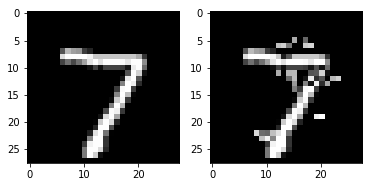

Score: [ 2.4867363  -0.19880557 -0.33954832  2.4577668  -3.2217598   0.8767169
 -4.19979     2.4739783   2.4632058   2.4649398 ]
output:  0
Total distortion: 4.037040868582999


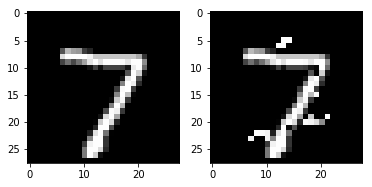

Score: [-1.1938654   5.418666    0.88596195 -0.6995132   0.30120307 -0.51244664
 -2.0166938   5.408204   -4.2103662  -0.47349593]
output:  1
Total distortion: 4.080501638503062


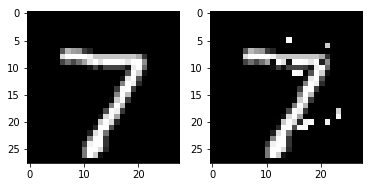

Score: [-1.0986396   1.7083812  15.060468    0.9801762   0.32628575 -7.0114145
 -8.972868   15.03784    -2.8318198  -4.8509808 ]
output:  2
Total distortion: 3.4832970016507327


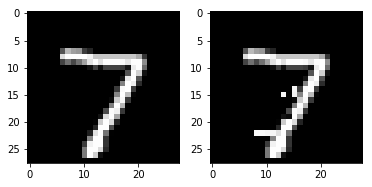

Score: [-6.8348093  1.0029113 -3.2212627 16.823725  -4.7537565  5.019751
 -9.693916  16.79242   -4.5038857  2.0877361]
output:  3
Total distortion: 2.6305349216459804


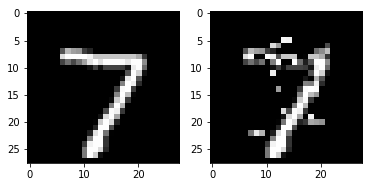

Score: [-1.1617653   1.7605965   0.85744214  0.35627934  1.7730373  -1.5827656
 -1.1859232   1.756212   -0.27015832  0.12224424]
output:  4
Total distortion: 4.322213994410337


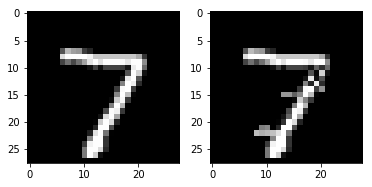

Score: [-4.487711   1.8605161 -6.555004  11.191686  -4.583283  11.252057
 -7.9705167 11.210875  -3.9613793  3.9671984]
output:  5
Total distortion: 2.803600217412809


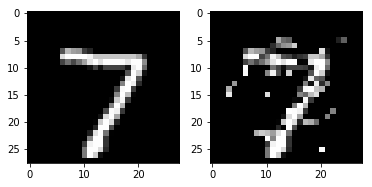

Score: [ 0.4448045   0.4447087  -0.17470291  0.25039235  0.44288993  0.44294685
  0.455037    0.43320954 -0.15384921 -0.27729475]
output:  6
Total distortion: 4.9810858609714925


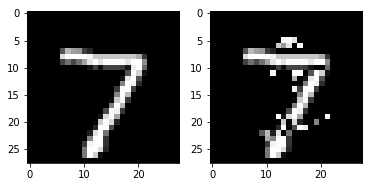

Score: [-0.6062796 -1.602387   2.6533718  4.4574895 -3.311094  -0.9735768
 -7.0174127  4.387175   4.469734   4.4506483]
output:  8
Total distortion: 4.421170990776934


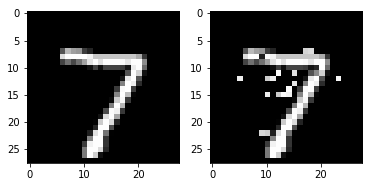

Score: [ -5.6781826  -1.4808445  -7.0457873  15.500554   -3.389056    5.826078
 -13.165292   15.492796   -2.9702451  15.522035 ]
output:  9
Total distortion: 3.7990507948076084


In [14]:


for org_img, adv_img in zip(inputs, adv):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(org_img, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(adv_img, (28,28)), cmap="gray")
#     plt.colorbar()
    plt.show()
    pred_score = model.model.predict(adv_img.reshape( (1,adv_img.shape[0],adv_img.shape[1],adv_img.shape[2] )))
    print("Score:",pred_score[0])
    print('output: ', np.argmax(pred_score[0]) )
    print("Total distortion:", np.sum((adv_img-org_img)**2)**.5)
    
#     break

In [ ]:
# for i in range(len(adv)):
#     print("Valid:")
#     show(inputs[i])
#     print("Adversarial:")
#     show(adv[i])

#     print("Classification:", model.model.predict(adv[i:i+1]))

#     print("Total distortion:", np.sum((adv[i]-inputs[i])**2)**.5)